In [144]:
from pathlib import Path
from configparser import ConfigParser
from joblib import load
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import itertools as itt

from ipywidgets import interact, fixed

In [128]:
config = ConfigParser()
config.read_file(open(Path('../config/settings.ini')))

True


In [48]:
oldTripDF = load(Path("../data/DF_summary/dprime_absolute-None_montecarlo-1000_raster_fs-30_reliability-0.1_smoothing_window-0_transitions-['silence', 'continuous', 'similar', 'sharp']_zscore-True"))
oldPermDF = load(Path('../data/prm_summary_DF_v2/dprime_absolute-None_montecarlo-1000_raster_fs-30_reliability-0.1_smoothing_window-0_transitions-[0, 1, 2, 3, 4]_zscore-True'))
newDF = load(Path('../data/consolidated_summary_DF/dprime_absolute-None_montecarlo-1000_raster_fs-30_reliability-0.1_smoothing_window-0_zscore-True'))

In [53]:
#Formats the old dataframes into the new naming systems and filters out old unused parameters and metadata
# create the id_probe pair

oldTripDF['stim_type'] = 'triplets'
oldPermDF['stim_type'] = 'permutations'

for odf in [oldTripDF, oldPermDF]:
    to_replace = {pname: pname.split('_')[-1] for pname in odf.probe.unique()}
    to_replace['dPCA'] = 'fdPCA'

    odf['id_probe'] = odf['cellid'].fillna(value=odf['siteid'])
    odf['id_probe'] = odf[['id_probe', 'probe']].agg('_'.join, axis=1)
    odf['mult_comp_corr'] = 'none'
    odf['mean_signif_type'] = 'mean'
    odf.replace(to_replace=to_replace, inplace=True)
    odf.rename(columns={'parameter':'metric',
                        'transition_pair': 'context_pair'}, inplace=True)


oldDF = pd.concat([oldTripDF, oldPermDF])

In [55]:
good_cols = ['id_probe', 'cellid', 'context_pair', 'probe', 'value', 'metric', 'mult_comp_corr',
             'mean_signif_type', 'stim_type', 'analysis', 'siteid', 'region']
ff_metric = oldDF.metric.isin(['significant_abs_sum', 'significant_abs_mass_center'])
oldDF = oldDF.loc[ff_metric, good_cols]

set()


In [60]:
newDF['id_probe'] = newDF['cellid'].fillna(value=newDF['siteid'])
newDF['id_probe'] = newDF[['id_probe', 'probe']].agg('_'.join, axis=1)

In [76]:
# compares old values with the same values recalculated on the new scripts, these should be identical.
nff_comp = newDF['mult_comp_corr'] == 'none'
nff_signif = newDF['mean_signif_type'] == 'mean'
nff_context = newDF['context_pair'] != 'mean'
nff_probe = newDF['probe'] != 'mean'
new_filtered = newDF.loc[nff_comp & nff_signif & nff_context & nff_probe, :].drop_duplicates()
print(new_filtered.shape)

off_comp = oldDF['mult_comp_corr'] == 'none'
off_signif = oldDF['mean_signif_type'] == 'mean'
off_context = oldDF['context_pair'] != 'mean'
off_probe = oldDF['probe'] != 'mean'
old_filtered = oldDF.loc[off_comp & off_signif & off_context & off_probe, :].drop_duplicates()
print(old_filtered.shape)


(60560, 12)
(67360, 12)


Here I am generaly comparing between the old and new approaches to calculate metrics. The difference in sites between
the old DF and the new one is based on some sitese that where excluded through empirical observation, namely the sites
{'AMT031a', 'DRX008b','DRX021a', 'DRX023a', 'ley074a' }
everytihg that is in the new DF was in the old one

In [83]:
for col in good_cols:
    if col == 'value':
        continue
    new = set(new_filtered[col].unique())
    old = set(old_filtered[col].unique())
    print(col, old.difference(new))

id_probe {'DRX008b-69-2_6', 'DRX008b-121-7_5', 'DRX008b-27-2_2', 'DRX008b-124-4_6', 'DRX008b-125-5_3', 'DRX008b-68-1_2', 'DRX008b-57-6_2', 'DRX008b-62-5_3', 'DRX008b-91-3_5', 'DRX023a-07-3_6', 'DRX008b-62-4_3', 'DRX021a-21-2_2', 'DRX008b-27-1_2', 'DRX008b-31-2_5', 'DRX021a-33-3_6', 'DRX021a-52-2_2', 'DRX021a-15-5_2', 'DRX008b-81-2_5', 'DRX021a-54-1_2', 'DRX008b-101-4_3', 'DRX021a-28-2_6', 'DRX008b-57-6_6', 'DRX008b-37-4_3', 'DRX023a-21-1_6', 'DRX021a-12-3_5', 'DRX008b-37-4_5', 'DRX008b-101-4_5', 'DRX021a-13-3_6', 'DRX008b-62-5_2', 'DRX021a-36-2_3', 'DRX023a-08-2_6', 'DRX023a-01-2_5', 'DRX021a-54-1_3', 'DRX008b-104-5_3', 'DRX008b-121-7_2', 'DRX021a-13-3_5', 'DRX023a-03-2_2', 'DRX021a-08-1_5', 'DRX008b-125-3_6', 'DRX008b-70-3_3', 'DRX021a-33-4_2', 'DRX021a-15-3_5', 'DRX021a-02-2_2', 'DRX008b-57-6_5', 'DRX021a-15-2_2', 'DRX021a-32-2_6', 'DRX008b-99-7_2', 'DRX008b-82-2_2', 'DRX008b-36-3_6', 'DRX008b-103-4_5', 'DRX023a-31-2_6', 'DRX021a-10-2_2', 'DRX008b-91-3_3', 'DRX021a-25-4_6', 'DRX023a-

In [113]:
# uses all columns but values to index
all_indices = ['id_probe', 'cellid', 'context_pair', 'probe', 'metric', 'mult_comp_corr',
             'mean_signif_type', 'stim_type', 'analysis', 'siteid', 'region']

new_with_idx = new_filtered.set_index(all_indices)
old_with_idx = old_filtered.set_index(all_indices)


full = pd.concat([new_with_idx, old_with_idx], axis=1, keys=['new', 'old'])
full.columns = full.columns.droplevel(1)

On visual inspection of the dataframe, there is a lot of Nan in the old array that are replaced as 0 in the new one,
this makes sense since i have started using masked arrays to deal with operations instead of nanmean and similar fuctions.
Most of the values coincide, howerver there are multiple numerical values that are absolutely different between old and new
further investigation is required.

Following is a scatter of the data

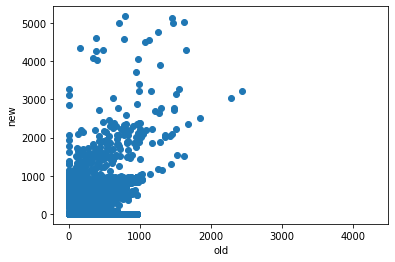

In [117]:
fig, ax = plt.subplots()
_ = ax.scatter(full['old'], full['new'])
_ = ax.set_xlabel('old')
_ = ax.set_ylabel('new')

In [124]:
# selects the most odd outliers, i.e. with the highest valu on one df and a low one in the other.

sorted = full.sort_values(['old', 'new'], axis=0, ascending=[1,0]).dropna()
print(sorted.head(10))

                                                                                                                                     new  \
id_probe  cellid context_pair       probe metric              mult_comp_corr mean_signif_type stim_type analysis siteid  region            
CRD002a_2 NaN    continuous_similar 2     significant_abs_sum none           mean             triplets  LDA      CRD002a A1       3281.3   
CRD002a_5 NaN    silence_similar    5     significant_abs_sum none           mean             triplets  LDA      CRD002a A1      3116.23   
CRD002a_3 NaN    continuous_similar 3     significant_abs_sum none           mean             triplets  LDA      CRD002a A1      2840.87   
AMT020a_2 NaN    silence_continuous 2     significant_abs_sum none           mean             triplets  LDA      AMT020a A1      2056.44   
AMT020a_6 NaN    silence_sharp      6     significant_abs_sum none           mean             triplets  LDA      AMT020a A1      1940.61   
AMT026a_5 NaN    sil

it is worthwile checking the dprimes using the old and new functions, at least for some of the most problematic values:

- site: CRD002a
- context_pair: continuous_similar
- probe: 2
- metric: significant_abs_sum
- mean_signif: none
- mean_signif_type: mean
- stim_type: triplets
- analysis: LDA
- new_val: 3281.3
- old_val: 0.0

In [145]:
from src.metrics.trp_batch_dprime import LDA_fourway_analysis as pLDA_old
from src.data.cache import make_cache, get_cache

meta_old = {'reliability': 0.1,  # r value
        'smoothing_window': 0,  # ms
        'raster_fs': 30,
        'transitions': ['silence', 'continuous', 'similar', 'sharp'],
        'montecarlo': 1000,
        'zscore': True,
        'dprime_absolute': None}

dprime_recache = False
rec_recache = False
two_tail_p = True

all_probes = [2, 3, 5, 6]

site = 'CRD002a'
probe = 2
func_key = 'LDA'


# cache location and function name
object_name = f'{site}_P{probe}_single_cell_dprime'
analysis_parameters = '_'.join(['{}-{}'.format(key, str(val)) for key, val in meta_old.items()])
analysis_name = f'CPN_{func_key}_dprime'
cache_folder = Path(config['paths']['analysis_cache']) / f'{analysis_name}/{analysis_parameters}'

SC_cache = make_cache(function=pLDA_old,
                      func_args={'site': site, 'probe': probe, 'meta': meta_old},
                      classobj_name=object_name,
                      cache_folder=cache_folder,
                      recache=dprime_recache)

dprime_old, shuf_dprime_old, _, _ = get_cache(SC_cache)


top_pval = np.sum((shuf_dprime_old >= dprime_old), axis=0) / meta_old['montecarlo']
bottom_pval = np.sum((shuf_dprime_old <= dprime_old), axis=0) / meta_old['montecarlo']
pval_old = np.where(dprime_old >= np.mean(shuf_dprime_old, axis=0), top_pval, bottom_pval)
significance_old = pval_old <= 0.01


function call (aka unique name):
CRD002a_P2_single_cell_dprime-LDA_fourway_analysis(meta={'reliability': 0.1, 'smoothing_window': 0, 'raster_fs': 30, 'transitions': ['silence', 'continuous', 'similar', 'sharp'], 'montecarlo': 1000, 'zscore': True, 'dprime_absolute': None}, probe=2, site=CRD002a)
hash: 1f0671debe5d10e8aa02c986d1d271245281cf67
 
cache found
loading cached file


In [155]:
from src.metrics.consolidated_dprimes import probewise_LDA_dprimes as pLDA_new

signif_tails = 'both'
alpha=0.01

meta_new = {'reliability': 0.1,  # r value
        'smoothing_window': 0,  # ms
        'raster_fs': 30,
        'montecarlo': 1000,
        'zscore': True,
        'dprime_absolute': None,
        'stim_type':  'triplets'}

permutations = {'contexts': [0, 1, 2, 3, 4],
                'probes': [1, 2, 3, 4]}

triplets = {'contexts': ['silence', 'continuous', 'similar', 'sharp'],
            'probes':[2, 3, 5, 6]}

dprime_new, shuffled_dprime_new, cellids, _ = pLDA_new(site, **triplets, meta=meta_new)


In [147]:
print(dprime_old.shape)
print(dprime_new.shape)


print('isclose', np.all(np.isclose(dprime_old,dprime_new[0,:,0,:])))

print(dprime_old-dprime_new[0,:,0,:])
# print(dprime_old)
# print(dprime_new[0,:,0,:])

(6, 30)
(1, 6, 4, 30)
isclose True
[[ 2.13162821e-14  1.33226763e-14  5.32907052e-15  1.19904087e-14
  -8.88178420e-16  8.88178420e-16 -6.66133815e-16 -7.10542736e-15
  -1.68753900e-14 -1.33226763e-15 -4.88498131e-15  1.77635684e-14
  -5.21804822e-15  1.77635684e-15 -8.43769499e-15  3.55271368e-15
   1.06581410e-14  8.88178420e-16  1.77635684e-15  1.77635684e-14
  -4.88498131e-15 -1.77635684e-15  9.76996262e-15 -5.32907052e-15
   1.24344979e-14 -8.88178420e-16 -4.66293670e-15 -1.77635684e-15
  -1.77635684e-15  0.00000000e+00]
 [ 3.28626015e-14  4.44089210e-16  2.13162821e-14  2.66453526e-15
   3.55271368e-15 -4.44089210e-15  0.00000000e+00 -4.44089210e-15
  -3.55271368e-15  3.55271368e-15 -6.21724894e-15 -8.88178420e-15
  -1.05471187e-14  5.32907052e-15 -6.21724894e-15  3.55271368e-15
   6.21724894e-15 -2.66453526e-15  5.32907052e-15  8.21565038e-14
  -4.61852778e-14 -1.77635684e-15 -3.55271368e-15  1.77635684e-15
   9.76996262e-15  0.00000000e+00  9.76996262e-15 -2.88657986e-14
   5.3

while the dprime values are not equal they are close to a fault, this makes me think that the discrepancies in the metrics
are not due to errors in the dprime calculation, but rather the metric calculations themselves

here I futher process the example site under both systems

#### old value:

old integral 0.0
old center of mass nan


/auto/users/mateo/miniconda3/envs/context_probe_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars


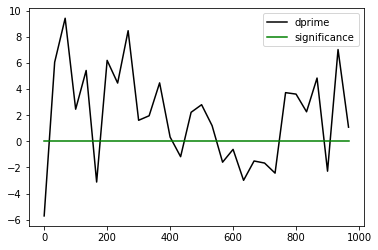

In [192]:
from src.metrics.dprime import flip_dprimes

# flips each time series in the dprime array, so the max absolute value is positive

array, _ = flip_dprimes(dprime_old, None, flip='max')

nbin = array.shape[-1]
times = np.linspace(0, nbin / meta_old['raster_fs'], nbin, endpoint=False) * 1000
t = times[:array.shape[-1]]

ctx_idx = [f'{t0}_{t1}' for t0, t1 in itt.combinations(meta_old['transitions'], 2)].index('continuous_similar')
mean = array[ctx_idx,:]
signif_mean = significance_old[ctx_idx,:]

signif_mask = signif_mean > 0



fig, ax = plt.subplots()
ax.plot(t, mean, color='black', label='dprime')
ax.plot(t, signif_mask, color='green', label='significance')
ax.legend()

# significant dprime absolute sum
old_int = np.sum(np.abs(mean[signif_mask])) * np.mean(np.diff(t))
print('old integral', old_int)

# significant dprime absolute center of mass

old_cntr = np.sum(np.abs(mean[signif_mask]) * t[signif_mask]) / np.sum(np.abs(mean[signif_mask]))
print('old center of mass', old_cntr)

#### new value

(1, 7, 5, 30)
[1, 7, 5, 30]
  cellid        context_pair probe   value               metric
3    NaN  continuous_similar     2  3281.3  significant_abs_sum
(1, 6, 4, 30)
(1, 6, 4, 30)


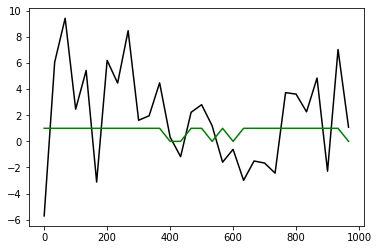

In [190]:
from src.metrics.significance import _significance, _mask_with_significance
from src.metrics.consolidated_metrics import metrics_to_DF

dim_lab_dict = {'cellid': [np.nan],
                'context_pair': [f'{c1}_{c2}' for c1, c2 in itt.combinations(triplets['contexts'], 2)],
                'probe': triplets['probes'],
                'time': np.linspace(0, dprime_new.shape[-1] / meta_new['raster_fs'], dprime_new.shape[-1],
                                    endpoint=False) * 1000}

significance, confidence_interval = _significance(dprime_new, shuffled_dprime_new, None,
                                                                    alpha=alpha)
fliped, _ = flip_dprimes(dprime_new, None, flip='sum')


# masks dprime with different significances, uses different approaches to define significance of the mean.
masked, masked_lab_dict = _mask_with_significance(fliped, significance, dim_lab_dict, mean_type='mean')


print(masked.shape)
print([len(s) for s in masked_lab_dict.values()])
# calculate different metrics and organize into a dataframe
metrics = ['significant_abs_mass_center', 'significant_abs_sum']
df = metrics_to_DF(masked, masked_lab_dict, metrics=metrics)

ff_metric = df.metric == 'significant_abs_sum'
ff_probe = df.probe == '2'
ff_ctx = df.context_pair == 'continuous_similar'
filtered =df.loc[ff_metric & ff_probe & ff_ctx, :]
print(filtered)


print(fliped.shape)
print(significance.shape)
prb_idx = triplets['probes'].index(2)
ctx_idx = [f'{t0}_{t1}' for t0, t1 in itt.combinations(triplets['contexts'], 2)].index('continuous_similar')

fig, ax = plt.subplots()
ax.plot(dim_lab_dict['time'], fliped[0,ctx_idx,prb_idx,:], color='black', label='dprime')
ax.plot(dim_lab_dict['time'], significance[0,ctx_idx,prb_idx,:], color='green', label='significance')

#### old and new values plus shuffle tests
it is clear that there is a huge discrepancy between these two. In this case I am tempted to think that
the culprit is bad shufling in the old approach. but its worth exploring.

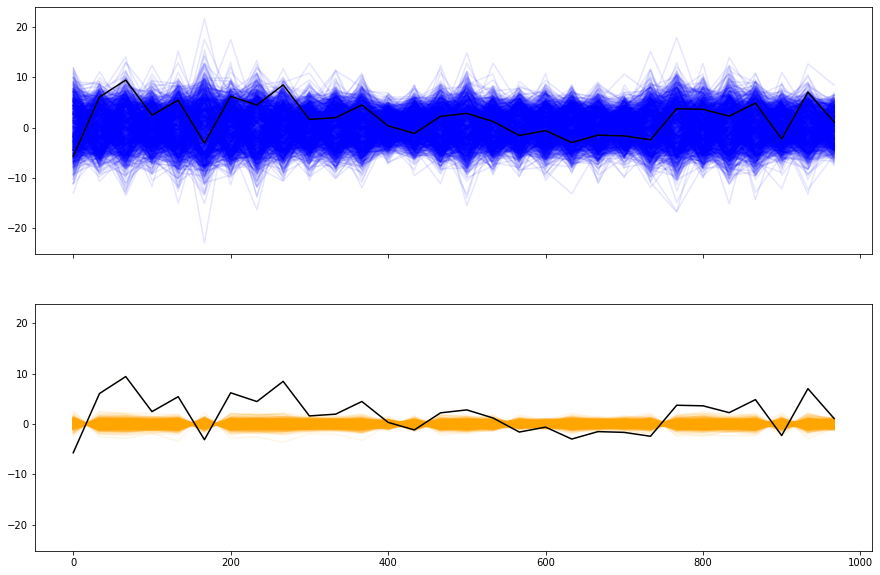

In [205]:
fig, (ax1,ax2) = plt.subplots(2,1,sharex=True, sharey=True, squeeze=True, figsize=(15,10))
_ = ax1.plot(t, shuf_dprime_old[:,ctx_idx,:].T, color='blue', alpha=0.1)
_ = ax1.plot(t, mean, color='black', label='dprime')
_ = ax2.plot(t, shuffled_dprime_new[:,0,ctx_idx, prb_idx,:].T, color='orange', alpha=0.1)
_ = ax2.plot(dim_lab_dict['time'], fliped[0,ctx_idx,prb_idx,:], color='black', label='dprime')

From checkin the code it is clear that there is a big issue on how fitting and shuffling is being done

The old approach is right, at least for LDA: It shuffles all the (4) contexts, then refits the LDA and finally calculates
d prime

The new approach, under a pretense of computationall efficienty, was transforming the data, selecting a pair of context
and shuffling them, before calculating dprime.

This was also done for single cell values. Is its rationale solid?? perhaps it is not for the single probe and context
pairs combinations, but it makes senses once all these values have been taken together for the site/cell grand mean.

At this moment I will try to make a copy of the consolidated dprimes (the new approach) and make sure I am refiting every
shuffle. This is computationally expensive, so the plan is to run it in the cluster.